In [3]:
from rich import print
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fp = "/home/numina/Documents/repos/CARL/experiments/attack_on_agents/tmp/2022-06-14/16-27-46/eval_data/eval_data.npz"
eval_data = np.load(fp, allow_pickle=True).item()
context = eval_data["context"]
transitions = eval_data["transitions"]
states = np.array([t[1] for t in transitions])
angles = np.arctan2(states[:, 1], states[:, 0]) % (2 * np.pi)
angles = angles / (2 * np.pi) * 360
angular_velocities = states[:, 2]

plt.scatter(angles, angular_velocities)
plt.show()

plt.hist(angles, bins=50, label="angles")
plt.xlabel(r"$\theta$")
plt.show()

plt.hist(angular_velocities, bins=50, label="velocities")
plt.xlabel(r"$\dot\theta$")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/numina/Documents/repos/CARL/experiments/attack_on_agents/tmp/2022-06-14/16-27-46/eval_data/eval_data.npz'

## Definitions for Gathering Data

In [10]:
import numpy as np
import glob
import os
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import itertools


def transitions_to_states(transitions):
    states = np.array([t[1] for t in transitions])
    # calculate angle with theta = atan2(y/x) = atan2(sin(theta)/cos(theta))
    angles = np.arctan2(states[:, 1], states[:, 0])
    angles = angles % (2 * np.pi) - np.pi  # move to range -pi, pi
    angles = angles / (2 * np.pi) * 360  # convert radian to degree
    angular_velocities = states[:, 2]
    return angles, angular_velocities


def normalize(A):
    A_min = np.amin(A)
    ptp = np.ptp(A)
    return (A - A_min) / ptp


def add_steps_to_episode_ids(E):
    S = np.zeros_like(E)
    k = 0
    e_last = 0
    for i, e in enumerate(E):
        if e != e_last:
            k = 0
            e_last = e
        S[i] = k
        k += 1
    return S


def get_states_and_performance(out_dir: str) -> pd.DataFrame:
    eval_data_fps = glob.glob(os.path.join(out_dir, "**", "eval_data/*.npz"), recursive=True)
    eval_data_list = [np.load(fp, allow_pickle=True).item() for fp in eval_data_fps]
    performance_list = np.array([D["performance"] for D in eval_data_list])
    performance_normalized = normalize(performance_list)
    state_list = [transitions_to_states(D["transitions"]) for D in eval_data_list]
    angle_list = [S[0] for S in state_list]
    velocity_list = [S[1] for S in state_list]

    P = np.concatenate([[perf] * len(a) for perf, a in zip(performance_list, angle_list)])
    Theta = np.concatenate(angle_list)
    Theta_dot = np.concatenate(velocity_list)
    context_ids = np.concatenate([[i] * len(a) for i, a in enumerate(angle_list)])

    transition_list = [D["transitions"] for D in eval_data_list]
    T = list(itertools.chain(*transition_list))
    E = [t[0] for t in T]
    steps = add_steps_to_episode_ids(E)


    data = pd.DataFrame({
        "performance": P,
        "angle": Theta,
        "angular_velocity": Theta_dot,
        "context_id": context_ids,
        "step": steps
    })
    return data


out_dir = "/home/numina/Documents/repos/CARL/experiments/attack_on_agents/tmp/2022-06-14/16-55-48"
out_dir = "/home/benjamin/Dokumente/code/tmp/CARL/experiments/attack_on_agents/tmp/2022-06-16/21-21-37"
out_dir = "/home/benjamin/Dokumente/code/tmp/CARL/tmp/2022-06-17/08-08-21"

# Random agent
# out_dir = "/home/benjamin/Dokumente/code/tmp/CARL/tmp/2022-06-17/12-30-00"  # random agent
# identifier = "random_agent"

# Trained agent
out_dir = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/tmp/2022-08-02/21-05-01/"  # trained agent
identifier = "trained_agent"

# Trained agent (no max_speeed)
out_dir = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/tmp/2022-08-08"
identifier = "trained_agent"

# Random agent (no max_speed)
out_dir = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/tmp/2022-08-09"
identifier = "random_agent"

## Plot Return per State // Context ID per State

/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/attack_on_agents


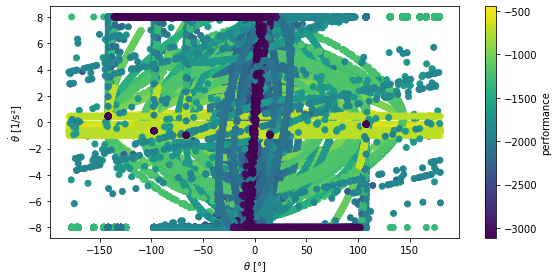

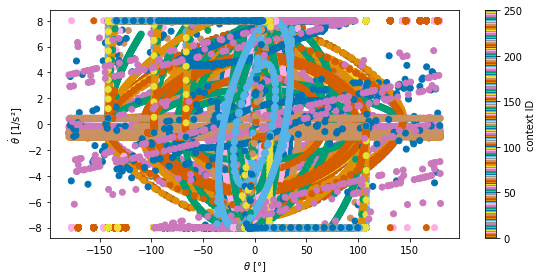

In [11]:
# Collect all states
# plt.rcParams['axes.grid'] = False

print(os.getcwd())
data = get_states_and_performance(out_dir=out_dir)


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
scatter = ax.scatter(x=data["angle"], y=data["angular_velocity"], c=data["performance"], cmap="viridis")
cbar_label = "performance"
ax.set_xlabel(r"$\theta$ [°]")
ax.set_ylabel(r"$\dot\theta$ [1/s²]")
fig.colorbar(scatter, ax=ax, label=cbar_label)
fig.set_tight_layout(True)
plt.show()
figfn = f"tmp/states_by_return_{identifier}.png"
fig.savefig(figfn, dpi=300, bbox_inches="tight")

# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(111)
# scatter = ax.scatter(x=Theta, y=Theta_dot, c=steps, cmap="viridis")
# cbar_label = "step"
# ax.set_xlabel(r"$\theta$ [°]")
# ax.set_ylabel(r"$\dot\theta$ [1/s²]")
# fig.colorbar(scatter, ax=ax, label=cbar_label)
# fig.set_tight_layout(True)
# plt.show()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
cmap = sns.color_palette("colorblind", n_colors=data["context_id"].nunique())
cmap = ListedColormap(cmap.as_hex())
scatter = ax.scatter(x=data["angle"], y=data["angular_velocity"], c=data["context_id"], cmap=cmap)
cbar_label = "context ID"
ax.set_xlabel(r"$\theta$ [°]")
ax.set_ylabel(r"$\dot\theta$ [1/s²]")
fig.colorbar(scatter, ax=ax, label=cbar_label)
fig.set_tight_layout(True)
plt.show()
figfn = f"tmp/states_by_context_{identifier}.png"
fig.savefig(figfn, dpi=300, bbox_inches="tight")

## Trained Agent Visited State Space
For `out_dir = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/tmp/2022-08-02/21-05-01/"`.
- state space much less covered
- overfit to train context


Find out:
- Histogram of return for random agent and trained agent
- How fast can BO find difficult contexts?

In [4]:
data

,performance,angle,angular_velocity,context_id,step
0,-154.330028,14.750476,-0.966945,0,0
1,-154.330028,10.575510,-1.457336,0,1
2,-154.330028,5.147913,-1.894588,0,2
3,-154.330028,-1.331177,-2.261630,0,3
4,-154.330028,-8.619015,-2.543935,0,4
...,...,...,...,...,...
250995,-1950.352036,108.004128,8.000000,250,195
250996,-1950.352036,107.896286,-8.000000,250,196
250997,-1950.352036,108.004128,8.000000,250,197
250998,-1950.352036,107.896286,-8.000000,250,198


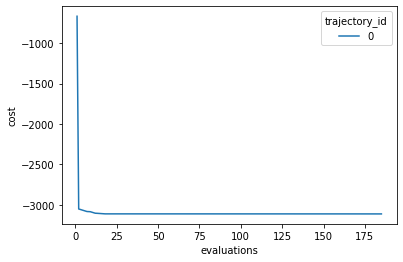

In [12]:
import glob
import os
import json
import pandas as pd


def read_trajectories(out_dir: str) -> pd.DataFrame:
    def read_jsonl(fp):
        with open(fp, 'r') as file:
            lines = file.readlines()
        data = [json.loads(l) for l in lines]
        return data

    smac_folders = glob.glob(os.path.join(out_dir, "**", "smac*", "run_*"), recursive=True)
    tj_id = "traj.json"
    trajectories = []
    for i, smac_folder in enumerate(smac_folders):
        traj_fp = os.path.join(smac_folder, tj_id)
        trajectory = read_jsonl(traj_fp)
        trajectory = pd.DataFrame(trajectory)
        trajectory["trajectory_id"] = i
        trajectory.drop([0], inplace=True)  # drop the first row bc it contains cost of 2e9
        trajectories.append(trajectory)

    # trajectories = pd.concat([pd.DataFrame(T) for T in trajectories])
    trajectories = pd.concat(trajectories)
    trajectories.reset_index(drop=True, inplace=True)
    return trajectories

trajectories = read_trajectories(out_dir=out_dir)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.lineplot(data=trajectories, x="evaluations", y="cost", hue="trajectory_id", ax=ax)
plt.show()

## Compare Trajectories
Between random and trained agents

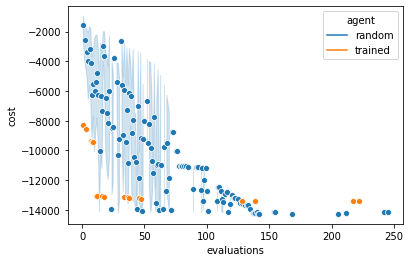

In [23]:
out_dirs = [
    "/home/benjamin/Dokumente/code/tmp/CARL/tmp/2022-06-17/12-30-00",  # random agent
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/tmp/2022-08-02/21-05-01/",  # trained agent
]
agents = ["random", "trained"]
trajectories_list = []
for i, out_dir in enumerate(out_dirs):
    agent = agents[i]
    trajectories = read_trajectories(out_dir=out_dir)
    trajectories["agent"] = [agent] * len(trajectories)
    trajectories_list.append(trajectories)
trajectories = pd.concat(trajectories_list).reset_index(drop=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.lineplot(data=trajectories, x="evaluations", y="cost", hue="agent", ax=ax, marker="o", ls="")
plt.show()

Trained agent deteriorates way faster than random agent.

## Difficulty of Contexts

In [13]:
import matplotlib as mpl

data  = get_states_and_performance(out_dir=out_dir)

# Cumulative performance per episode
groups = data.groupby("context_id")
df = groups.apply(lambda x: pd.Series({"mean": np.mean(x["performance"]), "std": np.std(x["performance"])}))
print(df["std"].max())
# std so small, can sort by mean
context_ids_sorted = df.sort_values(by="mean").index

def get_context_performance(out_dir: str) -> pd.DataFrame:
    eval_data_fps = glob.glob(os.path.join(out_dir, "**", "eval_data/*.npz"), recursive=True)
    eval_data_list = [np.load(fp, allow_pickle=True).item() for fp in eval_data_fps]
    performance_list = np.array([D["performance"] for D in eval_data_list])
    performance_normalized = normalize(performance_list)
    contexts = [pd.Series(D["context"]) for D in eval_data_list]
    context_ids = np.arange(0, len(contexts))

    data = pd.DataFrame({
        "performance": performance_list,
        "context_id": context_ids
    })
    data = data.join(pd.DataFrame(contexts))
    return data

data = get_context_performance(out_dir=out_dir)
if "initial_angle_max" in data:
    del data["initial_angle_max"]
if "initial_velocity_max" in data:
    del data["initial_velocity_max"]
if "max_speed" in data:
    del data["max_speed"]

P = data["performance"]
print(P.max())
P_norm = normalize(P)
cmap = mpl.cm.viridis
colors = cmap(P_norm)
# del data["performance"]
dimensions = [c for c in data.columns if c not in ['performance', 'context_id']]

import plotly.express as px
fig = px.parallel_coordinates(data, color="performance",
                              dimensions=dimensions,
                             color_continuous_scale="Viridis",
)
fig.show()

print("Worst context")
print(data[data["performance"] == data["performance"].min()])
print("Best context")
print(data[data["performance"] == data["performance"].max()])

1.3642420526593924e-12
-449.73549153581854


Worst context
     performance  context_id       dt          g         m         l
185 -3113.690378         185  0.01527  18.895579  9.960488  0.001001
Best context
    performance  context_id        dt         g         m         l
81  -449.735492          81  0.011235  0.001029  9.954563  9.954968


In [77]:
# Refit GPs
import glob
import os
from pathlib import Path

from smac.facade.smac_ac_facade import SMAC4AC
from smac.facade.smac_bb_facade import SMAC4BB
from smac.runhistory.runhistory import RunHistory
from smac.scenario.scenario import Scenario
from smac.stats.stats import Stats
from smac.utils.io.traj_logging import TrajLogger

smac_folders = glob.glob(os.path.join(out_dir, "**", "smac*", "run_*"), recursive=True)

for smac_folder in smac_folders:
    old_output_dir = smac_folder
    scenario_path = os.path.join(old_output_dir, "scenario.txt")
    smac_path = Path(smac_folder)
    os.chdir(smac_path.parent.parent)
    scenario = Scenario(scenario_path)

    # We load the runhistory
    rh_path = os.path.join(old_output_dir, "runhistory.json")
    runhistory = RunHistory()
    runhistory.load_json(rh_path, scenario.cs)

    # And the stats
    stats_path = os.path.join(old_output_dir, "stats.json")
    stats = Stats(scenario)
    stats.load(stats_path)

    # And the trajectory
    traj_path = os.path.join(old_output_dir, "traj_aclib2.json")
    trajectory = TrajLogger.read_traj_aclib_format(fn=traj_path, cs=scenario.cs)
    incumbent = trajectory[-1]["incumbent"]

    # Now we can initialize SMAC with the recovered objects and restore the
    # state where we left off. By providing stats and a restore_incumbent, SMAC
    # automatically detects the intention of restoring a state.
    smac = SMAC4BB(
        scenario=scenario,
        runhistory=runhistory,
        stats=stats,
        restore_incumbent=incumbent,
        run_id=1,
    )
    # TODO try DeepCAVE
    print(smac.solver.epm_chooser.model)
    break


Adding unsupported scenario options: {'save_results_instantly': 'True'}


<smac.epm.gaussian_process_mcmc.GaussianProcessMCMC object at 0x7f0218229bb0>